In [0]:
# Request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Download File
file_id = '19iPmzVwf4KavwzDPEe-XHECvxXlkeH9S' 
downloaded = drive.CreateFile({'id': file_id }) 

downloaded.GetContentFile('Teapots.mat')

In [0]:
#Load Packges
import numpy as np
import pandas as pd
from scipy.io import loadmat  

#Load Dat
teapot_data = loadmat('Teapots.mat')  
teapot_mats = teapot_data['Input'][0][0][0]
print(teapot_mats.shape)
print("Total Images:",teapot_mats.shape[1])
print("Pixels in each RGB Image: 76x101x3 =",teapot_mats.shape[0])

(23028, 400)
Total Images: 400
Pixels in each RGB Image: 76x101x3 = 23028


In [0]:
def vector_2_rgbimage(vector,h,w,c):
    image_rgb = vector.reshape(c,-1)
    image_rgb = image_rgb.T.reshape(w,h,c)
    image_rgb = np.rot90(image_rgb,3)
    return image_rgb

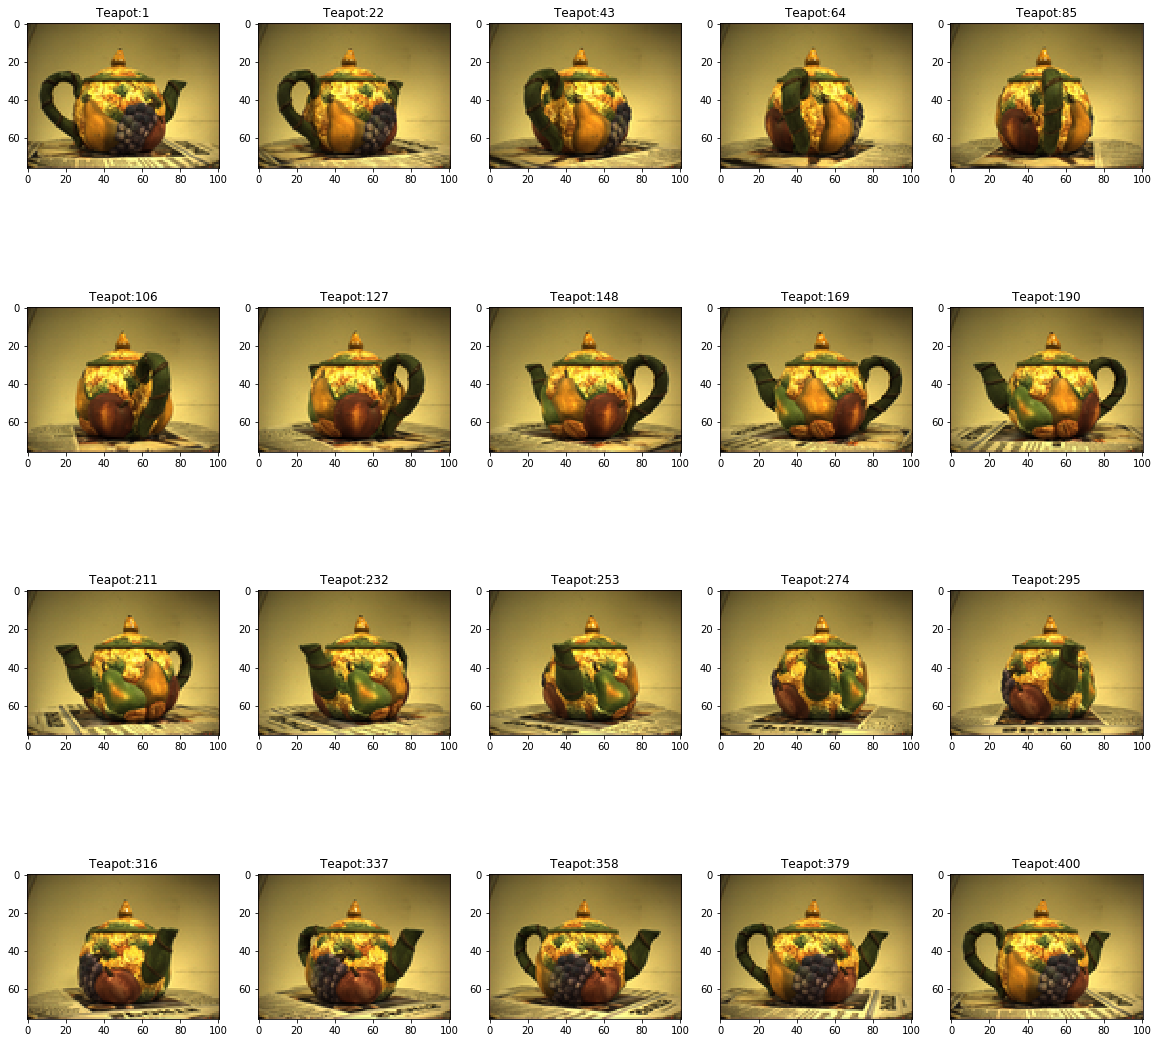

In [0]:
# 400 Teapot Images happen to be ordered by rotation
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))
rows, columns = 4,5
ax = []
skip = 20
DATA = []
for i in range(0, columns*rows):
    ith_image_index = i + i*skip 
    ith_vector = teapot_mats[:,ith_image_index]
    ith_image_rgb = vector_2_rgbimage(ith_vector,76,101,3)
    DATA.append(ith_vector)
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title("Teapot:"+str(ith_image_index+1)) 
    plt.imshow(ith_image_rgb)
plt.show()

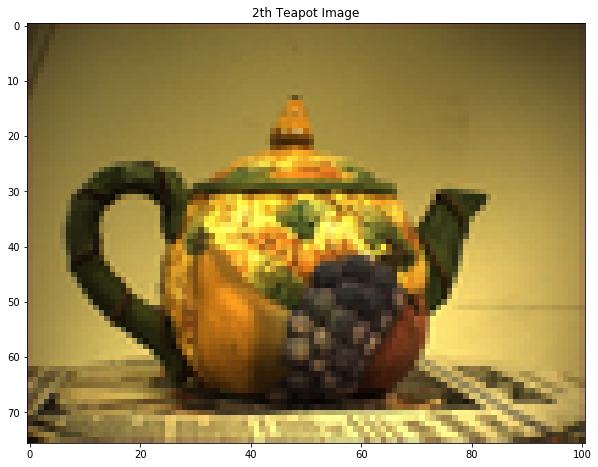

In [0]:
#Plot of individual image
#sns.reset_orig()

ith_image_index = 1 ## 0-399 Index
ith_vector = teapot_mats[:,ith_image_index]
ith_image_rgb = vector_2_rgbimage(ith_vector,76,101,3)

f, axI = plt.subplots(1, 1, sharey=True,figsize=(10, 200))

axI.set_title(str(ith_image_index+1)+"th Teapot Image")
axI.imshow(ith_image_rgb)

In [0]:
#https://github.com/buquicchiol/MaximumVarianceUnfolding/blob/master/MVU.py

#################################
## 1) MVU Code:
#################################
import cvxpy as cp
from scipy.sparse.csgraph import laplacian
from sklearn.neighbors import NearestNeighbors

class DisconnectError(Exception):
    """
    An error class to catch if the graph has unconnected regions.
    """

    def __init__(self, message):
        self.message = message


class MaximumVarianceUnfolding:

    def __init__(self, equation="berkley", solver=cp.SCS, solver_tol=1e-2,
                 eig_tol=1.0e-10, solver_iters=2500, warm_start=False, seed=None):
        """
        :param equation: A string either "berkley" or "wikipedia" to represent
                         two different equations for the same problem.
        :param solver: A CVXPY solver object.
        :param solver_tol: A float representing the tolerance the solver uses to know when to stop.
        :param eig_tol: The positive semi-definite constraint is only so accurate, this sets
                        eigenvalues that lie in -eig_tol < 0 < eig_tol to 0.
        :param solver_iters: The max number of iterations the solver will go through.
        :param warm_start: Whether or not to use a warm start for the solver.
                           Useful if you are running multiple tests on the same data.
        :param seed: The numpy seed for random numbers.
        """
        self.equation = equation
        self.solver = solver
        self.solver_tol = solver_tol
        self.eig_tol = eig_tol
        self.solver_iters = solver_iters
        self.warm_start = warm_start
        self.seed = seed
        self.neighborhood_graph = None

    def fit(self, data, k, dropout_rate=.2):
        """
        The method to fit an MVU model to the data.
        :param data: The data to which the model will be fitted.
        :param k: The number of neighbors to fix.
        :param dropout_rate: The number of neighbors to discount.
        :return: Embedded Gramian: The Gramian matrix of the embedded data.
        """
        # Number of data points in the set
        n = data.shape[0]

        # Set the seed
        np.random.seed(self.seed)

        # Calculate the nearest neighbors of each data point and build a graph
        N = NearestNeighbors(n_neighbors=k).fit(data).kneighbors_graph(data).todense()
        N = np.array(N)

        # Randomly drop certain connections.
        # Not the most efficient way but with this implementation random
        #  cuts that disconnect the graph will be caught.
        for i in range(n):
            for j in range(n):
                if N[i, j] == 1 and np.random.random() < dropout_rate:
                    N[i, j] = 0.

        # Save the neighborhood graph to be accessed latter
        self.neighborhood_graph = N

        # To check for disconnected regions in the neighbor graph
        lap = laplacian(N, normed=True)
        eigvals, _ = np.linalg.eig(lap)

        for e in eigvals:
            if e == 0. and self.solver_iters is None:
                raise DisconnectError("DISCONNECTED REGIONS IN NEIGHBORHOOD GRAPH. "
                                      "PLEASE SPECIFY MAX ITERATIONS FOR THE SOLVER")

        # Declare some CVXPy variables
        # Gramian of the original data
        P = cp.Constant(data.dot(data.T))
        # The projection of the Gramian
        Q = cp.Variable((n, n), PSD=True)
        # Initialized to zeros
        Q.value = np.zeros((n, n))
        # A shorter way to call a vector of 1's
        ONES = cp.Constant(np.ones((n, 1)))
        # A variable to keep the notation consistent with the Berkley lecture
        T = cp.Constant(n)

        # Declare placeholders to get rid of annoying warnings
        objective = None
        constraints = []

        # Wikipedia Solution
        if self.equation == "wikipedia":
            objective = cp.Maximize(cp.trace(Q))

            constraints = [Q >> 0, cp.sum(Q, axis=1) == 0]

            for i in range(n):
                for j in range(n):
                    if N[i, j] == 1:
                        constraints.append((P[i, i] + P[j, j] - P[i, j] - P[j, i]) -
                                           (Q[i, i] + Q[j, j] - Q[i, j] - Q[j, i]) == 0)

        # UC Berkley Solution
        if self.equation == "berkley":
            objective = cp.Maximize(cp.multiply((1 / T), cp.trace(Q)) -
                                    cp.multiply((1 / (T * T)), cp.trace(cp.matmul(cp.matmul(Q, ONES), ONES.T))))

            constraints = [Q >> 0, cp.sum(Q, axis=1) == 0]
            for i in range(n):
                for j in range(n):
                    if N[i, j] == 1.:
                        constraints.append(Q[i, i] - 2 * Q[i, j] + Q[j, j] -
                                           (P[i, i] - 2 * P[i, j] + P[j, j]) == 0)

        # Solve the problem with the SCS Solver
        problem = cp.Problem(objective, constraints)
        # FIXME The solvertol syntax is unique to SCS
        problem.solve(solver=self.solver,
                      eps=self.solver_tol,
                      max_iters=self.solver_iters,
                      warm_start=self.warm_start)

        return Q.value

    def fit_transform(self, data, dim, k, dropout_rate=.2):
        """
        The method to fit and transform an MVU model to the data.
        :param data: The data to which the model will be fitted.
        :param dim: The new dimension of the dataset.
        :param k: The number of neighbors to fix.
        :param dropout_rate: The number of neighbors to discount.
        :return: embedded_data: The embedded form of the data.
        """

        embedded_gramian = self.fit(data, k, dropout_rate)

        # Retrieve Q
        embedded_gramian = embedded_gramian

        # Decompose gramian to recover the projection
        eigenvalues, eigenvectors = np.linalg.eig(embedded_gramian)

        # Set the eigenvalues that are within +/- eig_tol to 0
        eigenvalues[np.logical_and(-self.eig_tol < eigenvalues, eigenvalues < self.eig_tol)] = 0.

        # Assuming the eigenvalues and eigenvectors aren't sorted,
        #    sort them and get the top "dim" ones
        sorted_indices = eigenvalues.argsort()[::-1]
        top_eigenvalue_indices = sorted_indices[:dim]

        # Take the top eigenvalues and eigenvectors
        top_eigenvalues = eigenvalues[top_eigenvalue_indices]
        top_eigenvectors = eigenvectors[:, top_eigenvalue_indices]

        # Some quick math to get the projection and return it
        lbda = np.diag(top_eigenvalues ** 0.5)
        embedded_data = lbda.dot(top_eigenvectors.T).T

        return embedded_data


class LandmarkMaximumVarianceUnfolding:

    def __init__(self, equation="berkley", landmarks=50, solver=cp.SCS, solver_tol=1e-2,
                 eig_tol=1.0e-10, solver_iters=2500, warm_start=False, seed=None):
        """
        :param equation: A string either "berkley" or "wikipedia" to represent
                         two different equations for the same problem.
        :param landmark: None if you do not want to use landmark MVU, otherwise the number of landmarks to consider.
        :param solver: A CVXPY solver object.
        :param solver_tol: A float representing the tolerance the solver uses to know when to stop.
        :param eig_tol: The positive semi-definite constraint is only so accurate, this sets
                        eigenvalues that lie in -eig_tol < 0 < eig_tol to 0.
        :param solver_iters: The max number of iterations the solver will go through.
        :param warm_start: Whether or not to use a warm start for the solver.
                           Useful if you are running multiple tests on the same data.
        :param seed: The numpy seed for random numbers.
        """
        self.equation = equation
        self.landmarks = landmarks
        self.solver = solver
        self.solver_tol = solver_tol
        self.eig_tol = eig_tol
        self.solver_iters = solver_iters
        self.warm_start = warm_start
        self.seed = seed
        self.neighborhood_graph = None

    def fit(self, data, k):
        """
        The method to fit an MVU model to the data.
        :param data: The data to which the model will be fitted.
        :param k: The number of neighbors to fix.
        :return: Embedded Gramian: The Gramian matrix of the embedded data.
        """
        # Number of data points in the set
        n = data.shape[0]

        # Set the seed
        np.random.seed(self.seed)

        # Calculate the nearest neighbors of each data point and build a graph
        N = NearestNeighbors(n_neighbors=k).fit(data).kneighbors_graph(data).todense()
        N = np.array(N)

        # Sort the neighbor graph to find the points with the most connections
        num_connections = N.sum(axis=0).argsort()[::-1]

        # Separate the most popular points
        top_landmarks_idxs = num_connections[:self.landmarks]
        top_landmarks = data[top_landmarks_idxs, :]

        # Compute the nearest neighbors for all of the landmarks so they are all connected
        L = NearestNeighbors(n_neighbors=3).fit(top_landmarks).kneighbors_graph(top_landmarks).todense()
        L = np.array(L)

        # The data without the landmarks
        new_data_idxs = [x for x in list(range(n)) if x not in top_landmarks_idxs]
        new_data = np.delete(data, top_landmarks_idxs, axis=0)

        # Construct a neighborhood graph where each point finds its closest landmark
        l = NearestNeighbors(n_neighbors=3).fit(top_landmarks).kneighbors_graph(new_data).todense()
        l = np.array(l)
        print("shape l", l.shape)

        # Reset N to all 0's
        N = np.zeros((n, n))

        # Add all of the intra-landmark connections to the neighborhood graph
        for i in range(self.landmarks):
            for j in range(self.landmarks):
                if L[i, j] == 1.:
                    N[top_landmarks_idxs[i], top_landmarks_idxs[j]] = 1.

        # Add all of the inter-landmark connections to the neighborhood graph
        for i in range(n - self.landmarks):
            for j in range(self.landmarks):
                if l[i, j] == 1.:
                    N[new_data_idxs[i], top_landmarks_idxs[j]] = 1.

        # Save the neighborhood graph to be accessed latter
        self.neighborhood_graph = N

        # To check for disconnected regions in the neighbor graph
        lap = laplacian(N, normed=True)
        eigvals, _ = np.linalg.eig(lap)

        for e in eigvals:
            if e == 0. and self.solver_iters is None:
                raise DisconnectError("DISCONNECTED REGIONS IN NEIGHBORHOOD GRAPH. "
                                      "PLEASE SPECIFY MAX ITERATIONS FOR THE SOLVER")

        # Declare some CVXPy variables
        # Gramian of the original data
        P = cp.Constant(data.dot(data.T))
        # The projection of the Gramian
        Q = cp.Variable((n, n), PSD=True)
        # Initialized to zeros
        Q.value = np.zeros((n, n))
        # A shorter way to call a vector of 1's
        ONES = cp.Constant(np.ones((n, 1)))
        # A variable to keep the notation consistent with the Berkley lecture
        T = cp.Constant(n)

        # Declare placeholders to get rid of annoying warnings
        objective = None
        constraints = []

        # Wikipedia Solution
        if self.equation == "wikipedia":
            objective = cp.Maximize(cp.trace(Q))

            constraints = [Q >> 0, cp.sum(Q, axis=1) == 0]

            for i in range(n):
                for j in range(n):
                    if N[i, j] == 1:
                        constraints.append((P[i, i] + P[j, j] - P[i, j] - P[j, i]) -
                                           (Q[i, i] + Q[j, j] - Q[i, j] - Q[j, i]) == 0)

        # UC Berkley Solution
        if self.equation == "berkley":
            objective = cp.Maximize(cp.multiply((1 / T), cp.trace(Q)) -
                                    cp.multiply((1 / (T * T)), cp.trace(cp.matmul(cp.matmul(Q, ONES), ONES.T))))

            constraints = [Q >> 0, cp.sum(Q, axis=1) == 0]
            for i in range(n):
                for j in range(n):
                    if N[i, j] == 1.:
                        constraints.append(Q[i, i] - 2 * Q[i, j] + Q[j, j] -
                                           (P[i, i] - 2 * P[i, j] + P[j, j]) == 0)

        # Solve the problem with the SCS Solver
        problem = cp.Problem(objective, constraints)
        # FIXME The solvertol syntax is unique to SCS
        problem.solve(solver=self.solver,
                      eps=self.solver_tol,
                      max_iters=self.solver_iters,
                      warm_start=self.warm_start)

        return Q.value

    def fit_transform(self, data, dim, k):
        """
        The method to fit and transform an MVU model to the data.
        :param data: The data to which the model will be fitted.
        :param dim: The new dimension of the dataset.
        :param k: The number of neighbors to fix.
        :return: embedded_data: The embedded form of the data.
        """

        embedded_gramian = self.fit(data, k)
        # Retrieve Q
        embedded_gramian = embedded_gramian

        # Decompose gramian to recover the projection
        eigenvalues, eigenvectors = np.linalg.eig(embedded_gramian)

        # Set the eigenvalues that are within +/- eig_tol to 0
        eigenvalues[np.logical_and(-self.eig_tol < eigenvalues, eigenvalues < self.eig_tol)] = 0.

        # Assuming the eigenvalues and eigenvectors aren't sorted,
        #    sort them and get the top "dim" ones
        sorted_indices = eigenvalues.argsort()[::-1]
        top_eigenvalue_indices = sorted_indices[:dim]

        # Take the top eigenvalues and eigenvectors
        top_eigenvalues = eigenvalues[top_eigenvalue_indices]
        top_eigenvectors = eigenvectors[:, top_eigenvalue_indices]

        # Some quick math to get the projection and return it
        lbda = np.diag(top_eigenvalues ** 0.5)
        embedded_data = lbda.dot(top_eigenvectors.T).T

        return embedded_data



In [0]:
# Transpose Data for MVU algorithm
rgb_400_images = teapot_mats.T
rgb_400_images = rgb_400_images.astype(np.float64)
print(rgb_400_images.shape)

(400, 23028)


In [0]:
def MVU_plot(L,K,D,color,data):
  # Run MVU (~takes 15 minutes or so)
  #L = 120 #Landmarks
  #K = 4 #K-nearest
  #D = 2 #Output Dimensions

  mx = LandmarkMaximumVarianceUnfolding(landmarks=L)
  embedded_data = mx.fit_transform(data=data,k=K,dim=D)
  
  mvu_teapot_df = pd.DataFrame(embedded_data)
  mvu_teapot_df.columns = ["MVU Dimension 1","MVU Dimension 2"]
  imgs = mvu_teapot_df.shape[0]

  import seaborn as sns; sns.set()
  sns.set_context("talk")
  pal = sns.light_palette(color,as_cmap=True)
  mvu_teapot_df["Color"] = np.sin(mvu_teapot_df.index*np.pi/(imgs-1))
  
  fig, ax = plt.subplots(figsize=(20,10))
  ax = sns.scatterplot(x="MVU Dimension 1", y="MVU Dimension 2", hue="Color",data=mvu_teapot_df,palette = pal)
  ax.legend_.remove()

  skip = 10
  for i in mvu_teapot_df.index:
    if (i % skip ==0):
        ax.annotate(i, (mvu_teapot_df.iloc[i]["MVU Dimension 1"], mvu_teapot_df.iloc[i]["MVU Dimension 2"]),size=15,weight='semibold',horizontalalignment='left')
  return mvu_teapot_df

shape l (320, 80)


,MVU Dimension 1,MVU Dimension 2,Color
0,500.960452,-12175.534016,0.000000e+00
1,500.960452,-12175.534016,7.873584e-03
2,2336.550310,-12219.500960,1.574668e-02
3,2378.131796,-12354.364603,2.361880e-02
4,2410.941994,-12437.253877,3.148946e-02
...,...,...,...
395,-342.853114,-12679.892128,3.148946e-02
396,-19.256300,-12358.241930,2.361880e-02
397,625.051275,-11204.951436,1.574668e-02
398,944.291318,-11055.125621,7.873584e-03


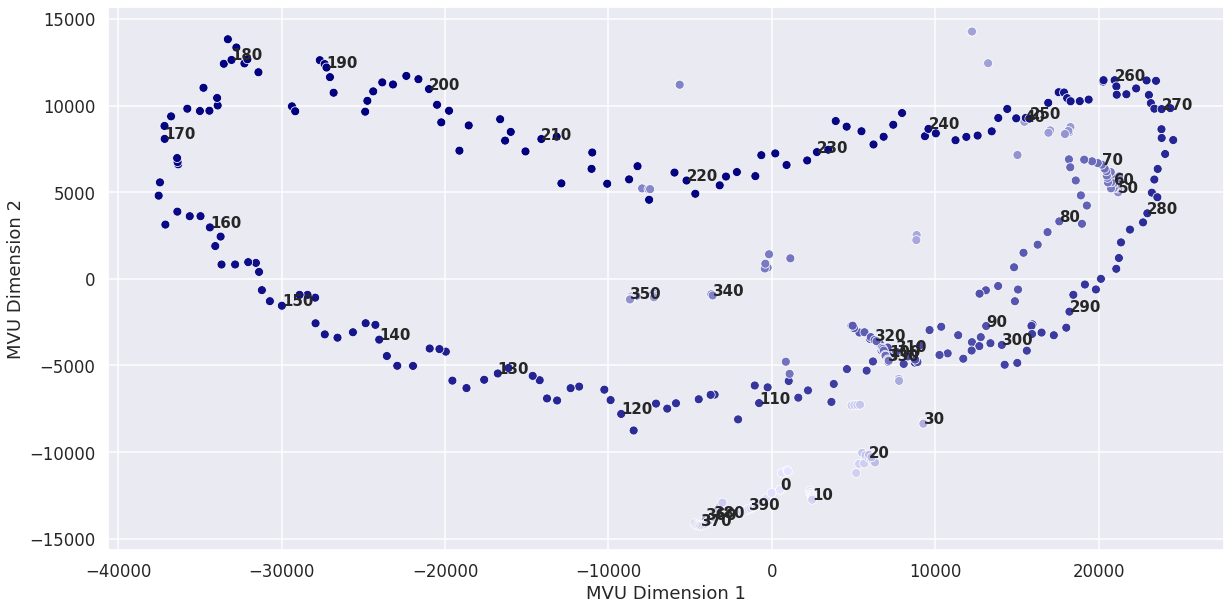

In [0]:
MVU_plot(80,4,2,"navy",rgb_400_images)

shape l (280, 120)


,MVU Dimension 1,MVU Dimension 2,Color
0,-23076.076094,-14145.490994,0.000000e+00
1,-23096.368504,-14174.584653,7.873584e-03
2,-22415.555673,-12968.273908,1.574668e-02
3,-22515.977836,-13050.775828,2.361880e-02
4,-22160.156365,-12404.698233,3.148946e-02
...,...,...,...
395,-23544.935452,-15159.758702,3.148946e-02
396,-23104.207992,-14460.106730,2.361880e-02
397,-22784.961352,-13902.320104,1.574668e-02
398,-22731.482463,-13736.242502,7.873584e-03


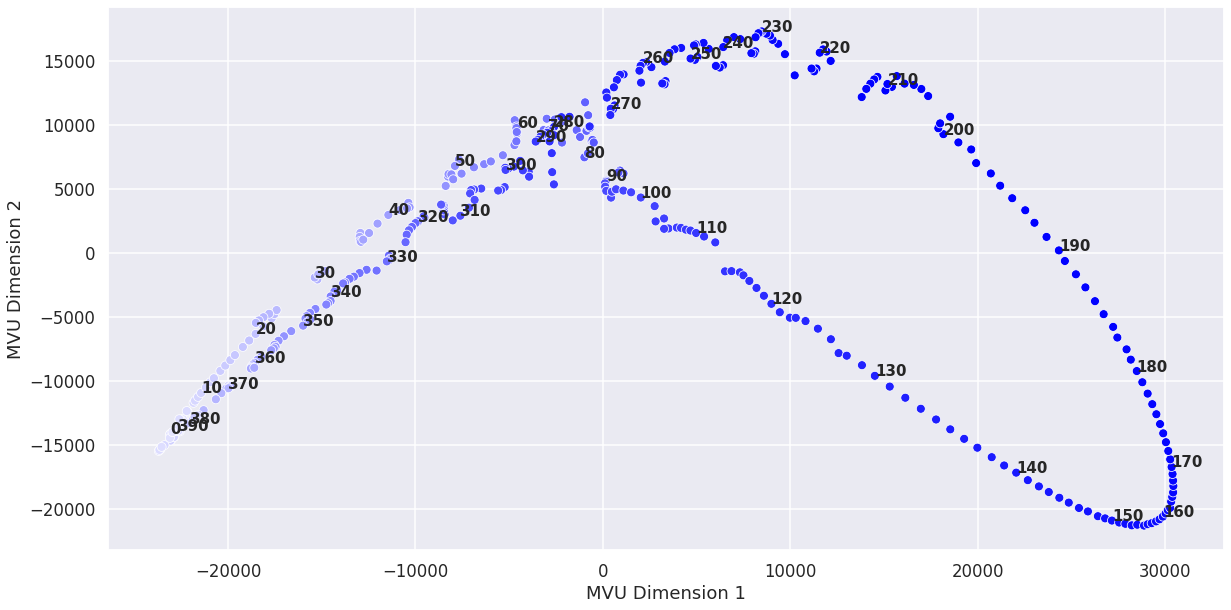

In [0]:
MVU_plot(120,6,2,"blue",rgb_400_images)

shape l (280, 120)


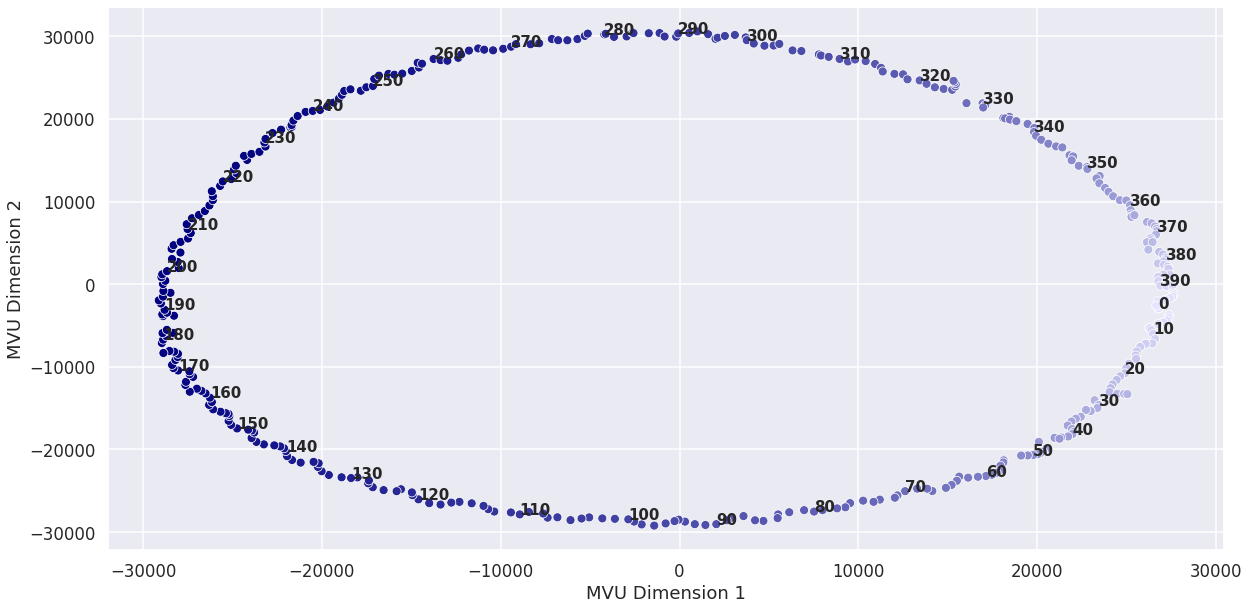

In [0]:
MVU_plot(120,4,2,"navy",rgb_400_images)

In [0]:
#Compare to PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(rgb_400_images)

pca_teapot_ = pca.transform(rgb_400_images) 
pca_teapot_df = pd.DataFrame(pca_teapot_)
pca_teapot_df.columns = ["Dimension 1","Dimension 2"]

pca_teapot_df["Color"] = np.sin(pca_teapot_df.index*np.pi/(imgs-1))

pca_teapot_df

,Dimension 1,Dimension 2,Color
0,-2498.698182,2684.291353,0.000000e+00
1,-2498.698182,2684.291353,7.873584e-03
2,-2486.341802,2571.953017,1.574668e-02
3,-2467.926609,2522.474384,2.361880e-02
4,-2451.441701,2476.927767,3.148946e-02
...,...,...,...
395,-2577.228345,2880.860699,3.148946e-02
396,-2566.730486,2842.914835,2.361880e-02
397,-2557.544396,2799.479054,1.574668e-02
398,-2555.361814,2756.347974,7.873584e-03


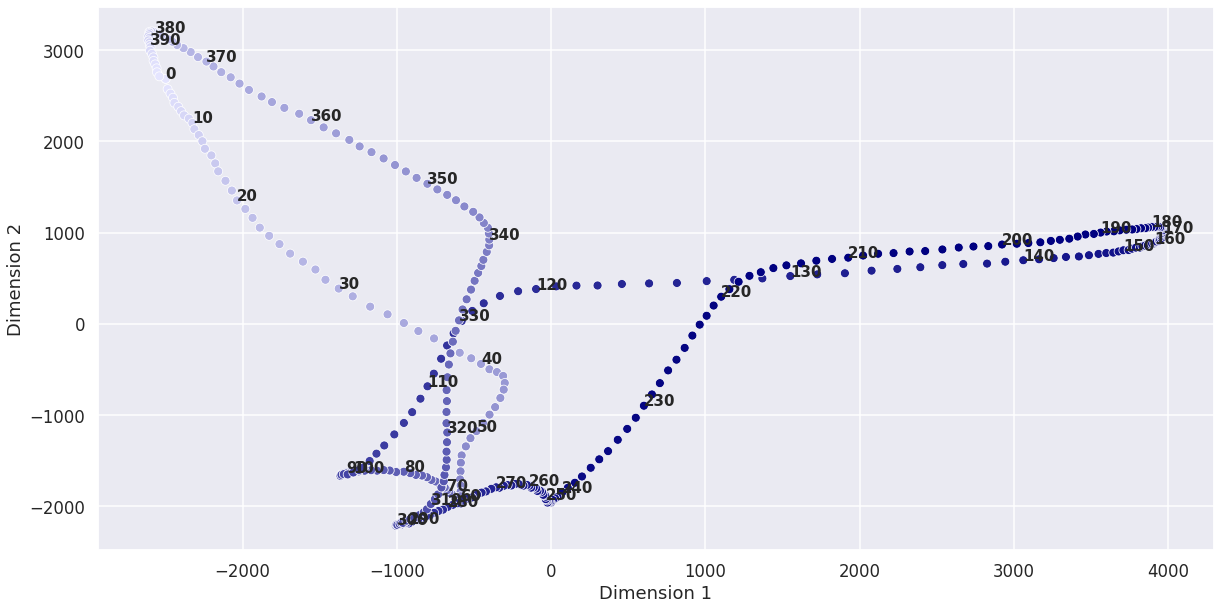

In [0]:
#Plot of MVU Embedded Data
sns.set_context("talk")

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x="Dimension 1", y="Dimension 2", hue="Color",data=pca_teapot_df,palette = pal)
ax.legend_.remove()

skip = 10
for i in pca_teapot_df.index:
    if (i % skip ==0):
        ax.annotate(i, (pca_teapot_df.iloc[i]["Dimension 1"], pca_teapot_df.iloc[i]["Dimension 2"]),size=15,weight='semibold',horizontalalignment='left')